## OAC - Prática 02
### Ponto-Flutuante IEEE-754 SP

#### Introdução

Site externo para apoio: [https://www.h-schmidt.net/FloatConverter/IEEE754.html](https://www.h-schmidt.net/FloatConverter/IEEE754.html) 

Outros sites utilizados:
- [RandomASCII](https://randomascii.wordpress.com/category/floating-point/) 
- [Wikipedia](https://en.wikipedia.org/wiki/IEEE_754)<sub>porque não, certo?</sub> 


#### Python vs ctypes

Para as nossas atividades, utilizaremos o formato IEEE-754 SP. Porém, Python representa números reais com o formato IEEE-754 DP, com 8 bytes (pf64|11|52), tornanto a vida do _escovador de bits_ um pouco árdua. 

Para contornar essa situação, invocaremos a biblioteca Python de compatibilidade com tipos da Linguagem de Programação C, chamada de `ctypes`, abusaremos dos tipos `int` (32bits) e `float` (32bits) e ganharemos de brinde a estrutura `Union`.


In [1]:
# nosso primeiro teste com ctypes, union e float
from ctypes import (Union, c_int, c_float)

class tipo_union(Union):
    _fields_ = ("int", c_int), ("float",c_float)

num1 = tipo_union()
num1.int = 0x3f800000
print("num1 =", num1.float)

num2 = tipo_union()
num2.float = 3.141565
print("num2 =", hex(num2.int))


num1 = 1.0
num2 = 0x40490f67


#### Getter e Setter para sinal e expoente 

Graças à estrutura `Union`, agora que podemos determinar todos os bits em hexadecimal (`inteiros`) e interpretá-los como `float`. Com isso, podemos elaborar métodos que configuram especificamente os campos `sinal`, `expoente` e `significando` utilizando a magia das instruções `shift`, `and` e `or`.

In [2]:
def get_sinal(n: int) -> int:
    """
    retorna 0 para (float) n positivo ou 1 para (float) n negativo
    """
    return (n.int >> 31) & 0x00000001

def set_sinal(n: int, sinal: int) -> int:
    """
    configura o (int) sinal 
    """
    return (sinal << 31) | n.int

def get_exp(n, k = False) -> int:
    """
    retorna os 8 bits expoente de (float) n no LSb
    """
    return (n.int >> 23) & 0x000000ff if k else ((n.int >> 23) & 0x000000ff) - 127

def set_exp(n:int, exp: int, k = False):
    """
    configura expoente de (float) n
    ----------
    n: int 
        valor, preferencialmente inteiro, para configuração de expoente
    exp: int
        valor a ser configurado como expoente, em int ou offset-binary (k)
    k: bool
        fator-k presente (True) ou não presente (False) em parâmetro exp
    """
    exp = exp if k else exp + 127
    exp = (exp << 23) & 0x7f800000      # limpa possível residuo em MSb
    return (n.int & 0x807fffff) | exp   # limpa exp original e substitui por novo exp

def get_significando(n: int, normalizado = True) -> int:
    """
    retorna o significando
    ----------
    n: int 
        valor, preferencialmente inteiro, para configuração de significando
    normalizado: Bool
        indica se retorno será normalizado (True / bit implícito) ou não (False / bit explícito)
    ----------
    Retorna n, sendo somente significando, excluindo bit de sinal e bits exp
    """
    return ((n.int & 0x007fffff) | 0x00800000) if not normalizado else (n.int & 0x007fffff)

def set_significando(n: int, significando: int, normalizado = True) -> int:
    """
    configura o significando de (float) n
    ----------
    n: int 
        valor, preferencialmente inteiro, para configuração de significando
    normalizado: Bool
        indica se o parâmetro n está normalizado (True / bit implícito) ou não (False / bit explícito)
    ----------
    Retorna n como um float completo
    """
    
    # TODO pelo aluno
    
    pass



num1 = tipo_union()
num1.int = 0x3f800000 # 0xbf800000
print(" sinal:",get_sinal(num1))
print("  expd:",get_exp(num1))
print("  expk:",get_exp(num1,True))
print("signi1:", hex(get_significando(num1, True)), "(extração direta, normalizada)")
print("signi2:", hex(get_significando(num1, False)), "(extração adicionando '1' implícito)")

num3 = tipo_union()
num3.int = set_sinal(num1,1)
print("sinal or :", num1.float)
print("sinal new:", num3.float)

num3.int = set_exp(num1, 8)
print("  ek = 8:", num3.float)
num3.int = set_exp(num1, 136, True)
print("ed = 136:", num3.float)

 sinal: 0
  expd: 0
  expk: 127
signi1: 0x0 (extração direta, normalizada)
signi2: 0x800000 (extração adicionando '1' implícito)
sinal or : 1.0
sinal new: -1.0
  ek = 8: 256.0
ed = 136: 512.0


### Atividade 01: getter e setter ausentes

Considerando o código getter e setter para sinal e significando, adicione os métodos `get_exp` e `set_significando` na Célula acima e realize testes.

### ULP 01 (Unit of Least Precision)
Considerando expoente e<sub>d</sub> = 0, encontrar: 

| variável | descrição|
|---------|-------------------------------------| 
|`nPiso`  | menor valor representável|
|`nPiso2` | segundo menor valor representável
|`diff`   |diferença entre `nPiso` e `nPiso2`
|`nTeto`  |maior valor representável

Após, criar uma lista com todos os números entre `nPiso` e `nTeto`, acumulando `diff`, e plotar um gráfico de linha relacionando cada valor da lista de acumulados com sua posição

nPiso  =1.0000000000000000000000000
nPiso2 =1.0000001192092895507812500
nTeto  =1.9999998807907104492187500
diferença entre nPiso e nPiso2  = 0.0000001192092895507812500
iterações de soma = 8.388.608
total acumulado   = 2.0000000000000000000000000


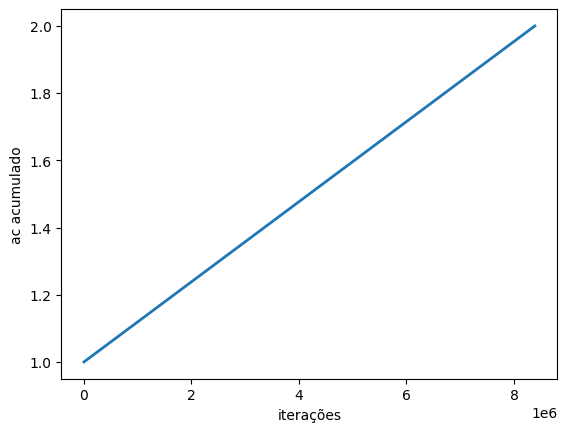

In [3]:
import matplotlib.pyplot as plt

# positivo, expoente 0d e significando = 0 (significando mínimo)
# menor valor com expoente 0d
nPiso = tipo_union()
nPiso.int = 0x3f800000
print("nPiso  ={:.25f}".format(nPiso.float))

nPiso2 = tipo_union()
nPiso2.int = 0x3f800001
print("nPiso2 ={:.25f}".format(nPiso2.float))

# positivo, expoente 0d e significando máximo
# maior valor com expoente 0d
nTeto = tipo_union()
nTeto.int = 0x3fffffff
print("nTeto  ={:.25f}".format(nTeto.float))

diff = (nPiso2.float - nPiso.float)
print("diferença entre nPiso e nPiso2  = {:.25f}".format(diff))

ac = nPiso.float
i = 0
graphY = []
while(ac <= nTeto.float):
    graphY.append(ac)
    i = i+1
    ac = ac + diff
    
    
graphX = range(i)

print("iterações de soma = {:,}".format(i).replace(",","."))
print("total acumulado   = {:.25f}".format(ac))

fig, ax = plt.subplots()
ax.set_xlabel('iterações')
ax.set_ylabel('ac acumulado')
ax.plot(graphX, graphY, linewidth=2.0)
plt.show()

#### ULP 01 - Extra 
O _gap_ para e<sub>d</sub> = 0 pode é realmente estimado por 2^(e<sub>d</sub>-p) ?


In [4]:
d = 0
gap = 2**(d-23)
print("ULP para ed = {} é {:,.25f}".format(d,gap).replace(",","."))

ULP para ed = 0 é 0.0000001192092895507812500


### Atividade 02: ULP 02

Refazer o código ULP 01, porém para e<sub>d</sub> = 30
- Observe o número de iterações e o total acumulado

In [5]:
   
# positivo, expoente 30d e significando = 0 (significando mínimo)
# menor valor com expoente 30d
nPiso = tipo_union()
nPiso.int = ?????
print("nPiso  ={:.25f}".format(nPiso.float))

# positivo, expoente 30d e significando = 1 (segundo significando mínimo)
nPiso2 = tipo_union()
nPiso2.int = ?????
print("nPiso2 ={:.25f}".format(nPiso2.float))

# positivo, expoente 30d e significando máximo
# maior valor com expoente 30d
nTeto = tipo_union()
nTeto.int = ?????
print("nTeto  ={:.25f}".format(nTeto.float))

diff = (nPiso2.float - nPiso.float)
print("diferença entre nPiso e nPiso2  = {:.25f}".format(diff))

# continue o código

SyntaxError: invalid syntax (2209037660.py, line 4)

#### ULPs de ePiso e eTeto para menor e maior expoentes (números positivos normalizados) para IEEE-754 SP

Encontrar o valor do menor e maior expoente para números positivos normalizados, sendo
- ePiso: menor expoente é e<sub>k</sub> = 00000001<sub>b</sub> = -126<sub>d</sub>
- eTeto: maior expoente é e<sub>k</sub> = 11111110<sub>b</sub> = 127<sub>d</sub>

Encontrar ULPs para ePiso e eTeto

In [6]:
ePiso = -126
eTeto = 127
ulpPiso = 2**(ePiso-23)
ulpTeto = 2**(eTeto-23)
print("ULP para ed = {} é {:E} ({:,.60f})".format(ePiso,ulpPiso,ulpPiso).replace(",","."))
print("ULP para ed = {} é {:E} ({:,})".format(eTeto,ulpTeto,ulpTeto).replace(",","."))

ULP para ed = -126 é 1.401298E-45 (0.000000000000000000000000000000000000000000001401298464324817)
ULP para ed = 127 é 2.028241E+31 (20.282.409.603.651.670.423.947.251.286.016)


#### Gráfico de ULPs 
Considerando o ePiso e eTeto anteriores, construir um gráfico contendo TODOS os ULPs dos números positivos 

Observação: não será é um gráfico muito elegante!

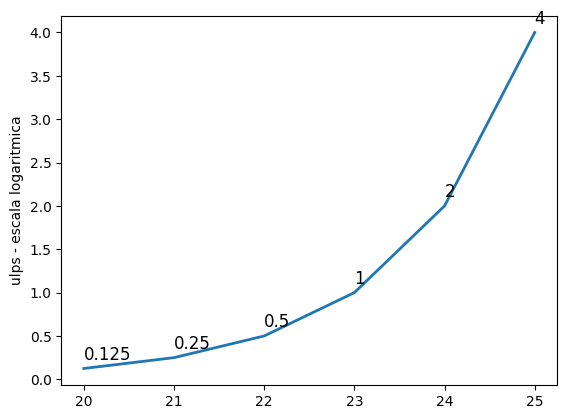

In [7]:
ePiso = 20   # -126
eTeto = 25   #  127

ulps = []

graphX = range(ePiso,eTeto+1)

for i in graphX:
    x = 2**(i-23)
    ulps.append(x)
    
fig, ax = plt.subplots()
ax.set_ylabel('ulps - escala logaritmica')
#ax.set_yscale('log')
for index in range(len(graphX)):
    ax.text(graphX[index], ulps[index]+0.1, ulps[index], size=12)
ax.plot(graphX, ulps, linewidth=2.0)
plt.show()


#### E a soma sucessiva? 



In [8]:
# soma sucessiva com parada != do anterior

base_t0 = tipo_union()
base_t1 = tipo_union()
base_t0.float = -1.0
base_t1.float = 1.0

exp_d = 0
inc = 2**(exp_d-23)          
contador = 0

print("ULP: {}".format(inc))

while( base_t0.float != base_t1.float): # comparação de floats com == ???? 
    base_t0.float = base_t1.float
    base_t1.float = base_t1.float + inc
    contador = contador + 1

print("contador: {:,} \n base_t0: {:E} \n base_t1: {:E}".format(contador, base_t0.float, base_t1.float).replace(",","."))



ULP: 1.1920928955078125e-07
contador: 8.388.609 
 base_t0: 2.000000E+00 
 base_t1: 2.000000E+00


### Atividade 03: Soma sucessiva

O código anterior da soma sucessiva finaliza após 8.388.609 iterações, o que é esperado. 

Porém, altere o código anterior para que `base_t1.float` inicie em: 
1. `base_t1.float = 2.0`, é necessário alterar o `exp_d` para o expoente que represente o 3.0
2. `base_t1.float = 0.0`, e verifique o número de iterações.  
    - Cuidado: o expoente continua sendo `exp_d = 0`, mesmo o 0.0 sendo um caso especial

Porque no item `1.`, apesar do contador finalizar com o valor esperado de 8.388.609, os valores finalizaram em `2*base_t1.float`?  

Porque no item `2.` o contador não foi o esperado e os valores finalizaram em `2.0`, semelhante ao código original com `base_t1.float = 1.0`?


## Entrega

O próprio arquivo ipynb no formato [OAC P02] nomeSobrenome1 nomeSobrenome2.ipynb com as células de saídas ativas.
- Neste ipynb, adicione células markdown relatando o processo de solução implementado pela dupla
  
Via Teams, até a data especificada na própria Tarefa